In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import random

In [2]:
env = gym.make("CartPole-v0")

# Random actions only

In [3]:
env.reset()
done = False
score = 0
frames = []

while not done:
    action = env.action_space.sample()
    new_state, reward, done, info = env.step(action)
    
    score += reward
    frames.append(Image.fromarray(env.render(mode="rgb_array")))
    
print(f"Total reward is: {score}")
env.close()

frames[0].save("CartPole Before Training Random Movement.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

C:\Users\Petar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Total reward is: 18.0


## Replay Memory

In [4]:
class ReplayMemory:
    def __init__(self, capacity, input_shape):
        self.capacity = capacity
        self.memory_counter = 0

        self.state_memory = np.zeros((self.capacity, *input_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.capacity, dtype=np.int64)
        self.reward_memory = np.zeros(self.capacity, dtype=np.float32)
        self.next_state_memory = np.zeros((self.capacity, *input_shape), dtype=np.float32)
        self.terminal_memory = np.zeros(self.capacity, dtype=np.uint8)

    def store(self, state, action, reward, next_state, done):
        index = self.memory_counter % self.capacity
        
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = done

        self.memory_counter += 1

    def sample(self, batch_size):
        max_memory = min(self.memory_counter, self.capacity)
        batch = np.random.choice(max_memory, batch_size, replace=False)

        states = self.state_memory[batch]
        next_states = self.next_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return min(self.memory_counter, self.capacity)

## Deep Q Network with 1 hidden layers

In [5]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions, lr):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(*input_shape, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.to(self.device)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Agents

## Q

In [6]:
class Agent_Q:
    def __init__(self, env, lr, epsilon_start, epsilon_end, epsilon_decay, discount):
        self.env = env
        self.observation_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        self.space_1 = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], 20)
        self.space_2 = np.linspace(self.env.observation_space.low[1], self.env.observation_space.high[1], 20)
        self.space_3 = np.linspace(self.env.observation_space.low[2], self.env.observation_space.high[2], 20)
        self.space_4 = np.linspace(self.env.observation_space.low[3], self.env.observation_space.high[3], 20)

        self.states = []
        for sp_1 in range(len(self.space_1)+1):
            for sp_2 in range(len(self.space_2)+1):
                for sp_3 in range(len(self.space_3)+1):
                    for sp_4 in range(len(self.space_4)+1):
                        self.states.append((sp_1, sp_2, sp_3, sp_4))
                
        self.Q_table = {}
        for state in self.states:
            for action in self.action_space:
                self.Q_table[state, action] = 0
        
    def get_state(self, observation):
        sp_1, sp_2, sp_3, sp_4 = observation
        space_1_bin = int(np.digitize(sp_1, self.space_1))
        space_2_bin = int(np.digitize(sp_2, self.space_2))
        space_3_bin = int(np.digitize(sp_3, self.space_3))
        space_4_bin = int(np.digitize(sp_4, self.space_4))
        
        return space_1_bin, space_2_bin, space_3_bin, space_4_bin
    
    def get_max_action(self, state):
        values = np.array([self.Q_table[state, action] for action in self.action_space])
        max_action = np.argmax(values)

        return max_action
        
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
    
    def choose_action(self, observation):
        if np.random.random() >= self.epsilon:
            action = self.get_max_action(observation)
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def save_agent(self, filename):
        print("=> Saving agent...")
        checkpoint = {
            "q_table": self.Q_table,
            "epsilon": self.epsilon
        }
        torch.save(checkpoint, filename)
        
    def load_agent(self, filename):
        print("=> Loading agent...")
        checkpoint = torch.load(filename)
        self.Q_table = checkpoint["q_table"]
        self.epsilon = checkpoint["epsilon"]
    
    def learn(self, state, action, reward, next_state):
        next_action = self.get_max_action(next_state)
        self.Q_table[state, action] = self.Q_table[state, action] + self.lr * (reward + self.discount * self.Q_table[next_state, next_action] - self.Q_table[state, action])
        
        self.update_epsilon()

## DQN

In [7]:
class Agent_DQN:
    def __init__(self, env, lr, epsilon_start, epsilon_end, epsilon_decay, discount):
        self.env = env
        self.state_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        self.q_online = DQN(self.state_shape, self.num_actions, self.lr)
        
    def choose_action(self, observation):
        # We use epsilon-greedy policy
        if np.random.random() >= self.epsilon:
            # In case that device is CUDA we have to sent it to GPU instead of CPU, also we have to transform it to torch tensor
            state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)
            with torch.no_grad():
                actions = self.q_online(state)
            # Take action with the highest value
            action = torch.argmax(actions).item()
        
        else:
            # Take random action in action space, eg. action space is [0, 1, 2] it takes 2nd action
            action = np.random.choice(self.action_space)
            
        return action
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
      
    def save_agent(self, filename):
        print("=> Saving agent...")
        checkpoint = {
            "q_online_state_dict": self.q_online.state_dict(),
            "optimizer_state_dict": self.q_online.optimizer.state_dict(),
            "epsilon": self.epsilon
        }
        torch.save(checkpoint, filename)
        
        
    def load_agent(self, filename):
        print("=> Loading agent...")
        checkpoint = torch.load(filename)
        self.q_online.load_state_dict(checkpoint["q_online_state_dict"])
        self.q_online.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.epsilon = checkpoint["epsilon"]
        
    def learn(self, state, action, reward, next_state):
        # Zero the gradients
        self.q_online.optimizer.zero_grad()
        
        # Turning numpy arrays into torch tensors
        state_t = torch.tensor(state, dtype=torch.float).to(self.q_online.device)
        action_t = torch.tensor(action, dtype=torch.int).to(self.q_online.device)
        reward_t = torch.tensor(reward, dtype=torch.float).to(self.q_online.device)
        next_state_t = torch.tensor(next_state, dtype=torch.float).to(self.q_online.device)
        
        # Estimating Q value
        q_pred = self.q_online(state_t)[action_t]
        q_next = self.q_online(next_state_t).max()
        q_target = reward + self.discount * q_next
        
        # Calculating loss
        loss = self.q_online.loss(q_target, q_pred).to(self.q_online.device)
        
        # Backprop
        loss.backward()
        self.q_online.optimizer.step()
        
        # Decrease epsilon
        self.update_epsilon()

## DQN with Replay Memory

In [8]:
class Agent_DQN_RM:
    def __init__(self, env, lr, batch_size, epsilon_start, epsilon_end, epsilon_decay, discount, memory_size, min_memory_size):
        self.env = env
        self.state_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.batch_size = batch_size
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Create experience replay buffer
        self.memory = ReplayMemory(memory_size, self.state_shape)
        # Fill minimal amount of experience needed before the training
        self.fill_min_memory(min_memory_size)
        
        self.q_online = DQN(self.state_shape, self.num_actions, self.lr)
        
    def fill_min_memory(self, min_memory_capacity):
        state = self.env.reset()
        done = False
        for _ in range(min_memory_capacity):
            action = self.choose_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.memory.store(state, action, reward, next_state, done)
            state = next_state

            if done:
                state = self.env.reset()
                done = False

    def choose_action(self, observation):
        # We use epsilon-greedy policy
        if np.random.random() >= self.epsilon:
            # In case that device is CUDA we have to sent it to GPU instead of CPU, also we have to transform it to torch tensor
            state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)
            with torch.no_grad():
                actions = self.q_online(state)
            # Take action with the highest value
            action = torch.argmax(actions).item()
        
        else:
            # Take random action in action space, eg. action space is [0, 1, 2] it takes 2nd action
            action = np.random.choice(self.action_space)
            
        return action
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
    
    def store(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)
        
    def sample(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Transform all numpy arrays into torch tensors
        states_t = torch.tensor(states).to(self.q_online.device)
        actions_t = torch.tensor(actions).to(self.q_online.device)
        rewards_t = torch.tensor(rewards).to(self.q_online.device)
        next_states_t = torch.tensor(next_states).to(self.q_online.device)
        dones_t = torch.tensor(dones).to(self.q_online.device)
        
        return states_t, actions_t, rewards_t, next_states_t, dones_t
    
    def save_agent(self, filename):
        print("=> Saving agent...")
        checkpoint = {
            "q_online_state_dict": self.q_online.state_dict(),
            "optimizer_state_dict": self.q_online.optimizer.state_dict(),
            "epsilon": self.epsilon,
            "memory_counter": self.memory.memory_counter,
            "state_memory": self.memory.state_memory,
            "action_memory": self.memory.action_memory,
            "reward_memory": self.memory.reward_memory,
            "next_state_memory": self.memory.next_state_memory,
            "terminal_memory": self.memory.terminal_memory
        }
        
        torch.save(checkpoint, filename)
        
    def load_agent(self, filename):
        print("=> Loading agent...")
        checkpoint = torch.load(filename)
        self.q_online.load_state_dict(checkpoint["q_online_state_dict"])
        self.q_online.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.epsilon = checkpoint["epsilon"]
        self.memory.memory_counter = checkpoint["memory_counter"]
        self.memory.state_memory = checkpoint["state_memory"]
        self.memory.action_memory = checkpoint["action_memory"]
        self.memory.reward_memory = checkpoint["reward_memory"]
        self.memory.next_state_memory = checkpoint["next_state_memory"]
        self.memory.terminal_memory = checkpoint["terminal_memory"]
        
    def learn(self):
        # In case that we don't have enough memory than don't learn
        if self.memory.memory_counter < self.batch_size:
            return
        # Zero the gradients
        self.q_online.optimizer.zero_grad()
        
        # Take sample of replay memory
        states, actions, rewards, next_states, dones = self.sample()
        
        indicies = np.arange(self.batch_size)
        q_pred = self.q_online(states)[indicies, actions]
        q_next = self.q_online(next_states).max(dim=1)[0]
        q_next[dones] = 0.0
        
        # Recalculating Q value
        q_target = rewards * self.discount * q_next
        
        # Calculating loss
        loss = self.q_online.loss(q_target, q_pred).to(self.q_online.device)
        
        # Backprop
        loss.backward()
        self.q_online.optimizer.step()
        
        # Decrease epsilon
        self.update_epsilon()

## DQN with Target Network and Replay Memory

In [9]:
class Agent_DQN_TN_RM:
    def __init__(self, env, lr, batch_size, epsilon_start, epsilon_end, epsilon_decay, discount, memory_size, min_memory_size, target_freq_update):
        self.env = env
        self.state_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.batch_size = batch_size
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_freq_update = target_freq_update
        
        # Create experience replay buffer
        self.memory = ReplayMemory(memory_size, self.state_shape)
        # Fill minimal amount of experience needed before the training
        self.fill_min_memory(min_memory_size)
        
        self.q_online = DQN(self.state_shape, self.num_actions, self.lr)
        self.q_target = DQN(self.state_shape, self.num_actions, self.lr)
        
        # Target and online network need to have same weights
        self.update_target_network()
        
    def fill_min_memory(self, min_memory_capacity):
        state = self.env.reset()
        done = False
        for _ in range(min_memory_capacity):
            action = self.choose_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.memory.store(state, action, reward, next_state, done)
            state = next_state

            if done:
                state = self.env.reset()
                done = False

    def choose_action(self, observation):
        # We use epsilon-greedy policy
        if np.random.random() >= self.epsilon:
            # In case that device is CUDA we have to sent it to GPU instead of CPU, also we have to transform it to torch tensor
            state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)
            with torch.no_grad():
                actions = self.q_online(state)
            # Take action with the highest value
            action = torch.argmax(actions).item()
        
        else:
            # Take random action in action space, eg. action space is [0, 1, 2] it takes 2nd action
            action = np.random.choice(self.action_space)
            
        return action
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
    
    def update_target_network(self):
        self.q_target.load_state_dict(self.q_online.state_dict())
    
    def store(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)
        
    def sample(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Transform all numpy arrays into torch tensors
        states_t = torch.tensor(states).to(self.q_online.device)
        actions_t = torch.tensor(actions).to(self.q_online.device)
        rewards_t = torch.tensor(rewards).to(self.q_online.device)
        next_states_t = torch.tensor(next_states).to(self.q_online.device)
        dones_t = torch.tensor(dones).to(self.q_online.device)
        
        return states_t, actions_t, rewards_t, next_states_t, dones_t
    
    def save_agent(self, filename):
        print("=> Saving agent...")
        checkpoint = {
            "q_online_state_dict": self.q_online.state_dict(),
            "optimizer_state_dict": self.q_online.optimizer.state_dict(),
            "q_target_state_dict": self.q_target.state_dict(),
            "epsilon": self.epsilon,
            "memory_counter": self.memory.memory_counter,
            "state_memory": self.memory.state_memory,
            "action_memory": self.memory.action_memory,
            "reward_memory": self.memory.reward_memory,
            "next_state_memory": self.memory.next_state_memory,
            "terminal_memory": self.memory.terminal_memory
        }
        
        torch.save(checkpoint, filename)
        
    def load_agent(self, filename):
        print("=> Loading agent...")
        checkpoint = torch.load(filename)
        self.q_online.load_state_dict(checkpoint["q_online_state_dict"])
        self.q_online.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.q_target.load_state_dict(checkpoint["q_target_state_dict"])
        self.epsilon = checkpoint["epsilon"]
        self.memory.memory_counter = checkpoint["memory_counter"]
        self.memory.state_memory = checkpoint["state_memory"]
        self.memory.action_memory = checkpoint["action_memory"]
        self.memory.reward_memory = checkpoint["reward_memory"]
        self.memory.next_state_memory = checkpoint["next_state_memory"]
        self.memory.terminal_memory = checkpoint["terminal_memory"]
    
    def learn(self):
        # In case that we don't have enough memory than don't learn
        if self.memory.memory_counter < self.batch_size:
            return
        # Zero the gradients
        self.q_online.optimizer.zero_grad()
        
        # Take sample of replay memory
        states, actions, rewards, next_states, dones = self.sample()
        
        indicies = np.arange(self.batch_size)
        q_pred = self.q_online(states)[indicies, actions]
        q_next = self.q_target(next_states).max(dim=1)[0]
        q_next[dones] = 0.0
        
        # Recalculating Q value
        q_target = rewards * self.discount * q_next
        
        # Calculating loss
        loss = self.q_online.loss(q_target, q_pred).to(self.q_online.device)
        
        # Backprop
        loss.backward()
        self.q_online.optimizer.step()
        
        # Decrease epsilon
        self.update_epsilon()

# Hyperparameters

In [10]:
NUM_ITERATIONS = 15_000
DISCOUNT = 0.99
LR = 1e-3
BATCH_SIZE = 64
MEMORY_SIZE = 1000
MIN_MEMORY_SIZE = 100
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 2e-5
TARGET_FREQ_UPDATE = 10
SHOW_FREQ = 100

# Training

## Q

In [11]:
agent_Q = Agent_Q(env, LR, EPSILON_START, EPSILON_END, EPSILON_DECAY, DISCOUNT)

score_history_Q, epsilon_history_Q = [], []
for iteration in range(NUM_ITERATIONS):
    done = False
    obs = agent_Q.env.reset()
    state = agent_Q.get_state(obs)
    score = 0
    
    while not done:
        action = agent_Q.choose_action(state)
        next_obs, reward, done, _ = agent_Q.env.step(action)
        next_state = agent_Q.get_state(next_obs)
        
        agent_Q.learn(state, action, reward, next_state)
        
        state = next_state
        score += reward
        
        
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_Q[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_Q.epsilon}")
    
    score_history_Q.append(score)
    epsilon_history_Q.append(agent_Q.epsilon)    

Episode: 100, Score: 14.0, Average Score: 22.35, Epsilon: 0.955019999999955
Episode: 200, Score: 32.0, Average Score: 22.66, Epsilon: 0.9093399999999093
Episode: 300, Score: 20.0, Average Score: 22.3, Epsilon: 0.864979999999865
Episode: 400, Score: 24.0, Average Score: 22.41, Epsilon: 0.8200799999998201
Episode: 500, Score: 11.0, Average Score: 21.77, Epsilon: 0.7767999999997768
Episode: 600, Score: 19.0, Average Score: 22.33, Epsilon: 0.731979999999732
Episode: 700, Score: 11.0, Average Score: 24.24, Epsilon: 0.6836599999996836
Episode: 800, Score: 21.0, Average Score: 20.62, Epsilon: 0.6422199999996422
Episode: 900, Score: 12.0, Average Score: 21.32, Epsilon: 0.5997599999995997
Episode: 1000, Score: 24.0, Average Score: 19.55, Epsilon: 0.5604199999995604
Episode: 1100, Score: 22.0, Average Score: 21.72, Epsilon: 0.517019999999517
Episode: 1200, Score: 15.0, Average Score: 20.34, Epsilon: 0.47647999999947643
Episode: 1300, Score: 27.0, Average Score: 19.0, Epsilon: 0.4382399999994382


Episode: 12500, Score: 22.0, Average Score: 15.47, Epsilon: 0.01
Episode: 12600, Score: 20.0, Average Score: 16.02, Epsilon: 0.01
Episode: 12700, Score: 11.0, Average Score: 15.8, Epsilon: 0.01
Episode: 12800, Score: 19.0, Average Score: 15.17, Epsilon: 0.01
Episode: 12900, Score: 12.0, Average Score: 14.93, Epsilon: 0.01
Episode: 13000, Score: 23.0, Average Score: 15.12, Epsilon: 0.01
Episode: 13100, Score: 11.0, Average Score: 15.13, Epsilon: 0.01
Episode: 13200, Score: 11.0, Average Score: 16.58, Epsilon: 0.01
Episode: 13300, Score: 24.0, Average Score: 16.13, Epsilon: 0.01
Episode: 13400, Score: 27.0, Average Score: 14.72, Epsilon: 0.01
Episode: 13500, Score: 11.0, Average Score: 15.09, Epsilon: 0.01
Episode: 13600, Score: 19.0, Average Score: 15.34, Epsilon: 0.01
Episode: 13700, Score: 12.0, Average Score: 15.65, Epsilon: 0.01
Episode: 13800, Score: 19.0, Average Score: 16.31, Epsilon: 0.01
Episode: 13900, Score: 12.0, Average Score: 15.91, Epsilon: 0.01
Episode: 14000, Score: 11.

In [12]:
agent_Q.save_agent(f"Q_agent_{agent_Q.lr}_{agent_Q.discount}.pth.tar")

=> Saving agent...


## DQN

In [13]:
agent_DQN = Agent_DQN(env, lr=LR, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY, discount=DISCOUNT)

epsilon_history_DQN, score_history_DQN = [], []
for iteration in range(NUM_ITERATIONS):
    state = agent_DQN.env.reset()
    done = False
    score = 0
    
    while not done:
        action = agent_DQN.choose_action(state)
        next_state, reward, done, _ = agent_DQN.env.step(action)
        
        # Iteration through DQN
        agent_DQN.learn(state, action, reward, next_state)
        
        state = next_state
        score += reward
    
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_DQN[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_DQN.epsilon}")
        
    # Add results to history
    score_history_DQN.append(score)
    epsilon_history_DQN.append(agent_DQN.epsilon)

C:\Users\Petar\AppData\Local\Temp/ipykernel_14500/2719848823.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)


Episode: 100, Score: 10.0, Average Score: 24.06, Epsilon: 0.9516799999999517
Episode: 200, Score: 40.0, Average Score: 22.14, Epsilon: 0.9067999999999068
Episode: 300, Score: 44.0, Average Score: 24.81, Epsilon: 0.8570999999998571
Episode: 400, Score: 42.0, Average Score: 24.0, Epsilon: 0.8091399999998091
Episode: 500, Score: 22.0, Average Score: 26.76, Epsilon: 0.756019999999756
Episode: 600, Score: 24.0, Average Score: 27.89, Epsilon: 0.7001999999997002
Episode: 700, Score: 13.0, Average Score: 27.5, Epsilon: 0.6454199999996454
Episode: 800, Score: 50.0, Average Score: 24.69, Epsilon: 0.5952999999995953
Episode: 900, Score: 21.0, Average Score: 27.19, Epsilon: 0.5414999999995415
Episode: 1000, Score: 28.0, Average Score: 22.95, Epsilon: 0.4954599999994954
Episode: 1100, Score: 36.0, Average Score: 20.48, Epsilon: 0.4543399999994543
Episode: 1200, Score: 19.0, Average Score: 22.26, Epsilon: 0.4101599999994101
Episode: 1300, Score: 9.0, Average Score: 26.77, Epsilon: 0.3568199999993567

Episode: 12600, Score: 10.0, Average Score: 12.03, Epsilon: 0.01
Episode: 12700, Score: 9.0, Average Score: 16.56, Epsilon: 0.01
Episode: 12800, Score: 10.0, Average Score: 11.81, Epsilon: 0.01
Episode: 12900, Score: 49.0, Average Score: 10.54, Epsilon: 0.01
Episode: 13000, Score: 10.0, Average Score: 10.84, Epsilon: 0.01
Episode: 13100, Score: 9.0, Average Score: 10.55, Epsilon: 0.01
Episode: 13200, Score: 9.0, Average Score: 10.9, Epsilon: 0.01
Episode: 13300, Score: 10.0, Average Score: 11.71, Epsilon: 0.01
Episode: 13400, Score: 9.0, Average Score: 12.73, Epsilon: 0.01
Episode: 13500, Score: 10.0, Average Score: 10.15, Epsilon: 0.01
Episode: 13600, Score: 10.0, Average Score: 11.61, Epsilon: 0.01
Episode: 13700, Score: 9.0, Average Score: 10.09, Epsilon: 0.01
Episode: 13800, Score: 8.0, Average Score: 11.83, Epsilon: 0.01
Episode: 13900, Score: 10.0, Average Score: 11.77, Epsilon: 0.01
Episode: 14000, Score: 10.0, Average Score: 12.06, Epsilon: 0.01
Episode: 14100, Score: 10.0, Ave

In [14]:
agent_DQN.save_agent(f"DQN_agent_{agent_DQN.lr}_{agent_DQN.discount}.pth.tar")

=> Saving agent...


## DQN with Replay Memory

In [15]:
agent_DQN_RM = Agent_DQN_RM(env, lr=LR, batch_size=BATCH_SIZE, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY, discount=DISCOUNT, memory_size=MEMORY_SIZE, min_memory_size=MEMORY_SIZE)

epsilon_history_DQN_RM, score_history_DQN_RM = [], []
for iteration in range(NUM_ITERATIONS):
    state = agent_DQN_RM.env.reset()
    done = False
    score = 0
    
    while not done:
        action = agent_DQN_RM.choose_action(state)
        next_state, reward, done, _ = agent_DQN_RM.env.step(action)
        
        # Add new experience to memory
        agent_DQN_RM.memory.store(state, action, reward, next_state, int(done))
        agent_DQN_RM.learn()
        
        state = next_state
        score += reward
    
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_DQN_RM[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_DQN_RM.epsilon}")
        
    # Add results to history
    score_history_DQN_RM.append(score)
    epsilon_history_DQN_RM.append(agent_DQN_RM.epsilon)

C:\Users\Petar\AppData\Local\Temp/ipykernel_14500/2000207317.py:112: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  q_next[dones] = 0.0
C:\Users\Petar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\autograd\__init__.py:154: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  Variable._execution_engine.run_backward(


Episode: 100, Score: 17.0, Average Score: 22.38, Epsilon: 0.9548999999999549
Episode: 200, Score: 13.0, Average Score: 22.75, Epsilon: 0.9094799999999095
Episode: 300, Score: 14.0, Average Score: 23.56, Epsilon: 0.8623399999998623
Episode: 400, Score: 17.0, Average Score: 26.62, Epsilon: 0.809039999999809
Episode: 500, Score: 26.0, Average Score: 22.61, Epsilon: 0.7636399999997636
Episode: 600, Score: 16.0, Average Score: 21.94, Epsilon: 0.7199599999997199
Episode: 700, Score: 23.0, Average Score: 21.92, Epsilon: 0.675979999999676
Episode: 800, Score: 53.0, Average Score: 21.38, Epsilon: 0.6326199999996326
Episode: 900, Score: 22.0, Average Score: 22.67, Epsilon: 0.5878999999995879
Episode: 1000, Score: 32.0, Average Score: 21.66, Epsilon: 0.5443799999995443
Episode: 1100, Score: 18.0, Average Score: 23.13, Epsilon: 0.49839999999949836
Episode: 1200, Score: 22.0, Average Score: 22.6, Epsilon: 0.45311999999945307
Episode: 1300, Score: 23.0, Average Score: 24.3, Epsilon: 0.40449999999940

Episode: 12500, Score: 28.0, Average Score: 29.51, Epsilon: 0.01
Episode: 12600, Score: 22.0, Average Score: 30.49, Epsilon: 0.01
Episode: 12700, Score: 61.0, Average Score: 29.72, Epsilon: 0.01
Episode: 12800, Score: 36.0, Average Score: 28.51, Epsilon: 0.01
Episode: 12900, Score: 42.0, Average Score: 26.05, Epsilon: 0.01
Episode: 13000, Score: 20.0, Average Score: 30.61, Epsilon: 0.01
Episode: 13100, Score: 43.0, Average Score: 28.03, Epsilon: 0.01
Episode: 13200, Score: 24.0, Average Score: 30.26, Epsilon: 0.01
Episode: 13300, Score: 13.0, Average Score: 26.79, Epsilon: 0.01
Episode: 13400, Score: 53.0, Average Score: 25.32, Epsilon: 0.01
Episode: 13500, Score: 21.0, Average Score: 28.33, Epsilon: 0.01
Episode: 13600, Score: 31.0, Average Score: 27.5, Epsilon: 0.01
Episode: 13700, Score: 34.0, Average Score: 26.95, Epsilon: 0.01
Episode: 13800, Score: 29.0, Average Score: 29.79, Epsilon: 0.01
Episode: 13900, Score: 26.0, Average Score: 28.1, Epsilon: 0.01
Episode: 14000, Score: 30.0

In [16]:
agent_DQN_RM.save_agent(f"DQN_RM_agent_{agent_DQN_RM.lr}_{agent_DQN_RM.discount}_{agent_DQN_RM.memory.capacity}.pth.tar")

=> Saving agent...


## DQN with Target Network and Replay Memory

In [17]:
agent_DQN_TN_RM = Agent_DQN_TN_RM(env, lr=LR, batch_size=BATCH_SIZE, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY, discount=DISCOUNT, memory_size=MEMORY_SIZE, min_memory_size=MEMORY_SIZE, target_freq_update=TARGET_FREQ_UPDATE)

epsilon_history_DQN_TN_RM, score_history_DQN_TN_RM = [], []
for iteration in range(NUM_ITERATIONS):
    state = agent_DQN_TN_RM.env.reset()
    done = False
    score = 0
    
    if iteration % agent_DQN_TN_RM.target_freq_update == 0 and iteration != 0:
        agent_DQN_TN_RM.update_target_network()
    
    while not done:
        action = agent_DQN_TN_RM.choose_action(state)
        next_state, reward, done, _ = agent_DQN_TN_RM.env.step(action)
        
        # Add new experience to memory
        agent_DQN_TN_RM.memory.store(state, action, reward, next_state, int(done))
        agent_DQN_TN_RM.learn()
        
        state = next_state
        score += reward
    
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_DQN_TN_RM[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_DQN_TN_RM.epsilon}")
        
    # Add results to history
    score_history_DQN_TN_RM.append(score)
    epsilon_history_DQN_TN_RM.append(agent_DQN_TN_RM.epsilon)
    

C:\Users\Petar\AppData\Local\Temp/ipykernel_14500/2963098315.py:122: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  q_next[dones] = 0.0


Episode: 100, Score: 22.0, Average Score: 22.13, Epsilon: 0.9552999999999553
Episode: 200, Score: 27.0, Average Score: 24.92, Epsilon: 0.9053599999999054
Episode: 300, Score: 16.0, Average Score: 22.18, Epsilon: 0.8612199999998612
Episode: 400, Score: 12.0, Average Score: 29.03, Epsilon: 0.8032399999998032
Episode: 500, Score: 13.0, Average Score: 31.55, Epsilon: 0.7401199999997401
Episode: 600, Score: 49.0, Average Score: 39.77, Epsilon: 0.6598599999996598
Episode: 700, Score: 52.0, Average Score: 31.06, Epsilon: 0.5976799999995976
Episode: 800, Score: 164.0, Average Score: 45.92, Epsilon: 0.5035999999995036
Episode: 900, Score: 129.0, Average Score: 50.34, Epsilon: 0.40361999999940357
Episode: 1000, Score: 200.0, Average Score: 112.36, Epsilon: 0.17747999999927808
Episode: 1100, Score: 200.0, Average Score: 162.65, Epsilon: 0.01
Episode: 1200, Score: 157.0, Average Score: 134.22, Epsilon: 0.01
Episode: 1300, Score: 200.0, Average Score: 164.27, Epsilon: 0.01
Episode: 1400, Score: 67.

Episode: 12400, Score: 187.0, Average Score: 173.34, Epsilon: 0.01
Episode: 12500, Score: 200.0, Average Score: 193.96, Epsilon: 0.01
Episode: 12600, Score: 117.0, Average Score: 171.05, Epsilon: 0.01
Episode: 12700, Score: 26.0, Average Score: 176.78, Epsilon: 0.01
Episode: 12800, Score: 68.0, Average Score: 178.3, Epsilon: 0.01
Episode: 12900, Score: 120.0, Average Score: 146.4, Epsilon: 0.01
Episode: 13000, Score: 200.0, Average Score: 137.77, Epsilon: 0.01
Episode: 13100, Score: 48.0, Average Score: 157.84, Epsilon: 0.01
Episode: 13200, Score: 35.0, Average Score: 163.62, Epsilon: 0.01
Episode: 13300, Score: 95.0, Average Score: 136.12, Epsilon: 0.01
Episode: 13400, Score: 200.0, Average Score: 124.12, Epsilon: 0.01
Episode: 13500, Score: 52.0, Average Score: 115.87, Epsilon: 0.01
Episode: 13600, Score: 105.0, Average Score: 100.98, Epsilon: 0.01
Episode: 13700, Score: 200.0, Average Score: 155.18, Epsilon: 0.01
Episode: 13800, Score: 165.0, Average Score: 175.06, Epsilon: 0.01
Epi

In [18]:
agent_DQN_TN_RM.save_agent(f"DQN_TN_RM_agent_{agent_DQN_TN_RM.lr}_{agent_DQN_TN_RM.discount}_{agent_DQN_TN_RM.memory.capacity}_{agent_DQN_TN_RM.target_freq_update}.pth.tar")

=> Saving agent...


# Testing

## Q

In [19]:
done = False
score = 0
frames = []
obs = agent_Q.env.reset()
state = agent_Q.get_state(obs)
while not done:
    next_obs, reward, done, _ = agent_Q.env.step(action)
    next_state = agent_Q.get_state(next_obs)
        
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_Q.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_Q.env.close()

frames[0].save("CartPole Q Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 8.0


## DQN

In [20]:
done = False
score = 0
frames = []
state = agent_DQN.env.reset()
while not done:
    with torch.no_grad():
        action = agent_DQN.choose_action(state)
        
    next_state, reward, done, _ = agent_DQN.env.step(action)
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_DQN.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_DQN.env.close()

frames[0].save("CartPole DQN Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 9.0


## DQN with Replay Memory

In [21]:
done = False
score = 0
state = agent_DQN_RM.env.reset()
while not done:
    with torch.no_grad():
        action = agent_DQN_RM.choose_action(state)
        
    next_state, rewards, done, _ = agent_DQN_RM.env.step(action)
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_DQN_RM.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_DQN_RM.env.close()

frames[0].save("CartPole DQN RM Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 10.0


## DQN with Target Network and Replay Memory

In [22]:
done = False
score = 0
frames = []
state = agent_DQN_TN_RM.env.reset()
while not done:
    with torch.no_grad():
        action = agent_DQN_TN_RM.choose_action(state)
        
    next_state, rewards, done, _ = agent_DQN_TN_RM.env.step(action)
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_DQN_TN_RM.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_DQN_TN_RM.env.close()

frames[0].save("CartPole DQN TN RM Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 102.0


# Results

In [23]:
def plot_training(x_label, y_label, values, legend_labels, colors, average_freq, xlim, ylim, figsize=(12, 10), filename=None):
    assert len(legend_labels) == len(values)
    
    # Creating a figure
    fig = plt.figure(figsize=figsize)
    plt.xlabel(x_label, color="black")
    plt.ylabel(y_label, color="black")
    
    for value, label, color in zip(values, legend_labels, colors):
        value_len = len(value)
        running_average = np.empty(value_len)
        for timestep in range(value_len):
            running_average[timestep] = np.mean(value[max(0, timestep-average_freq):timestep+1])
        
        plt.plot([x_value for x_value in range(value_len)], running_average, color=color, label=label)
        
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

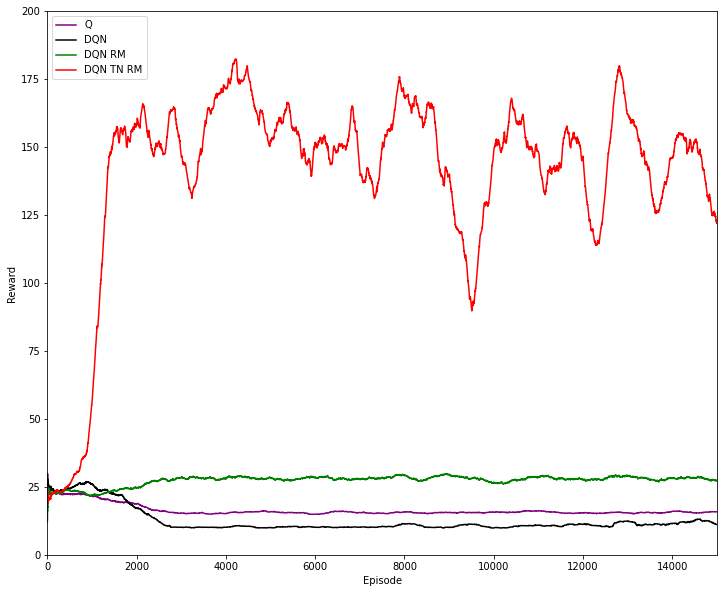

In [24]:
score_histories = [score_history_Q, score_history_DQN, score_history_DQN_RM, score_history_DQN_TN_RM]
labels = ["Q", "DQN", "DQN RM", "DQN TN RM"]
colors = ["purple", "black", "green", "red", "blue"]
plot_training("Episode", "Reward", score_histories, labels, colors, 500, NUM_ITERATIONS, 200, filename="Comparing Algorithms on CartPole.png")

# Conclusion

## Q
It was obvious that Q learning won't work because CartPole environment has 4 parameters in observation space and if we take 21 buckets, because space is continuous and we want to make it discrete, we will have too many non-explored states. Training for such model would take really long time. This method can work for environments with less parameters like MountainCar (2 parameters that are velocity and position), but it will still take around 30k episodes to train from my experience.

## DQN
It works, but it is highly unstable. We can see that because one episode it peaks and next episodes it drops down to random-action-like quality.

## DQN with Replay Memory
This method finally gives good results, but without the target network loss function is not performing properly. We can compare this to playing Hide and Seek in real life, but whenever we make a move to find a someone's location, person that is hiding also moves.

## DQN with Target Network and Replay Memory
This is by far the best and most stable method. Obvious improvement is to create Double DQN, Dueling DQN, Double Dueling DQN, etc. Using techniques such as prioritized replay memory could help aswell.